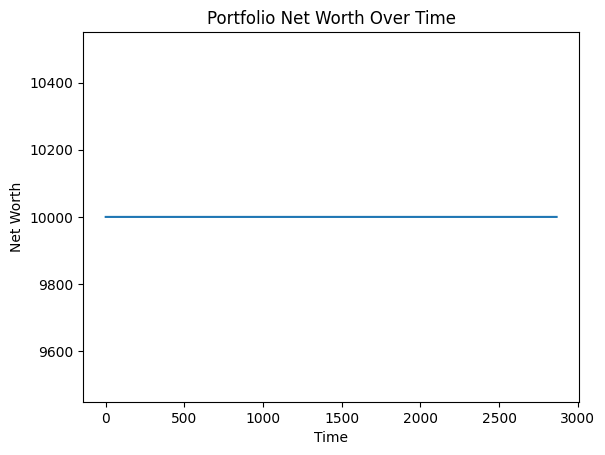

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

T = 60
P = 7
M = 4
R = 0.8
F = 0.0005

# Function to get data from a CSV file
def GetData(NameOfFile):
    data = pd.read_csv(NameOfFile)
    data = data[["datadate", "tic", "adjcp"]]
    return data

# Function to partition the data by date
def PartitionData(data):
    partitioned_data = []
    date_to_index = {}
    unique_dates = data['datadate'].unique()
    for i, date in enumerate(unique_dates):
        partition = data[data['datadate'] == date]
        partitioned_data.append(partition)
        date_to_index[date] = i
    return partitioned_data, date_to_index

# Function to switch between two stocks
def Switch(first_stock, second_stock, today, partitioned_dataframes):
    stock1_data = partitioned_dataframes[today][first_stock]['adjcp']
    stock2_data = partitioned_dataframes[today][second_stock]['adjcp']
    stock1_future_avg = stock1_data.mean()
    stock2_future_avg = stock2_data.mean()
    if stock1_future_avg > stock2_future_avg:
        return first_stock
    else:
        return second_stock

# Portfolio class
class Portfolio:
    def __init__(self, initial_balance):
        self.initial_balance = initial_balance
        self.current_balance = initial_balance
        self.stock_holdings = np.zeros(30)
        self.stock_prices = np.zeros(30)
        self.pairs = []
    
    def SellStock(self, index):
        shares = self.stock_holdings[index]
        stock_price = self.stock_prices[index]
        transaction_fee = stock_price * shares * F
        self.current_balance += shares * stock_price - transaction_fee
        self.stock_holdings[index] = 0
    
    def BuyStock(self, index, number):
        stock_price = self.stock_prices[index]
        transaction_fee = stock_price * number * F
        if self.current_balance >= (stock_price * number + transaction_fee):
            self.current_balance -= (stock_price * number + transaction_fee)
            self.stock_holdings[index] += number
    
    def CalculateNetWorth(self):
        net_worth = self.current_balance + np.dot(self.stock_holdings, self.stock_prices)
        return net_worth
    
    def ChangePricesTo(self, new_price_vector):
        self.stock_prices = new_price_vector
    
    def ChangePairs(self):
        self.pairs = []
        correlations = np.corrcoef(self.stock_prices)
        for i in range(30):
            for j in range(i+1, 30):
                correlation = correlations[i, j]
                self.pairs.append((i, j))
        self.pairs = sorted(self.pairs, key=lambda x: correlation, reverse=True)[:M]
    
    def RebalancePortfolio(self):
        if len(self.pairs) == 0:
            return
        stocks_in_pairs = set([stock for pair in self.pairs for stock in pair])
        for stock in stocks_in_pairs:
            stock_count = sum([1 for pair in self.pairs if stock in pair])
            current_holding = self.stock_holdings[stock]
            target_holding = R * self.CalculateNetWorth() / self.stock_prices[stock] / stock_count
            if current_holding < target_holding:
                self.BuyStock(stock, target_holding - current_holding)
            elif current_holding > target_holding:
                self.SellStock(stock)

# Function to visualize the data
def VisualizeData(net_worth):
    plt.plot(net_worth)
    plt.xlabel('Time')
    plt.ylabel('Net Worth')
    plt.title('Portfolio Net Worth Over Time')
    plt.show()

# Main program
def main():
    # Get the data
    data = GetData(r"C:\Users\soura\Downloads\DATA.csv")
    partitioned_data, date_to_index = PartitionData(data)

    # Initialize the portfolio
    myPortfolio = Portfolio(10000)
    NetWorthAfterEachTrade = []

    # Start processing from the (T+1)th day
    for i in range(T, len(partitioned_data)):
        # Change the prices to the ith term
        prices = partitioned_data[i]['adjcp'].values
        myPortfolio.ChangePricesTo(prices)

        # Calculate net worth and store it
        net_worth = myPortfolio.CalculateNetWorth()
        NetWorthAfterEachTrade.append(net_worth)

        # Check if you need to rebalance the portfolio
        if (i - T) % P == 0:
            myPortfolio.RebalancePortfolio()

        # Check if you need to switch stocks today
        if (i - T) % P == 0:
            for pair in myPortfolio.pairs:
                stock1, stock2 = pair
                chosen_stock = Switch(stock1, stock2, i, partitioned_data)
                if chosen_stock != stock1:
                    myPortfolio.SellStock(stock1)
                    myPortfolio.BuyStock(stock2, R * myPortfolio.CalculateNetWorth() / myPortfolio.stock_prices[stock2])

    # Visualize the net worth
    VisualizeData(NetWorthAfterEachTrade)

if __name__ == "__main__":
    main()